In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm

In [3]:
import cv2
from fastai import *
from fastai.vision import *

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [5]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [6]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_lighting=0.15, max_zoom=1.5, max_warp=0.)

In [7]:
np.random.seed(42)

In [8]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

## Calc dataset intensity statistics

In [9]:
channel_mean = [0.2716068709636366, 0.11716740675990968, 0.31234732880144966]
channel_std = [0.0470964828476292, 0.03501106218376086, 0.04154600651232207]

In [10]:
'''
r_mean, g_mean, b_mean = 0., 0., 0.
r_std, g_std, b_std = 0., 0., 0.
for path in tqdm(fnames):

    image = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    _, binary_inv = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY_INV)

    image = image / 255.

    array = np.ma.array(image, mask=binary_inv)
    r_mean += np.ma.mean(array[:, :, 0])
    g_mean += np.ma.mean(array[:, :, 1])
    b_mean += np.ma.mean(array[:, :, 2])

    r_std += np.ma.std(array[:, :, 0])
    g_std += np.ma.std(array[:, :, 1])
    b_std += np.ma.std(array[:, :, 2])   
    
channel_mean = [r_mean / len(fnames), g_mean  / len(fnames), b_mean  / len(fnames)]
channel_std = [r_std  / len(fnames), g_std  / len(fnames), b_std  / len(fnames)]
'''

'\nr_mean, g_mean, b_mean = 0., 0., 0.\nr_std, g_std, b_std = 0., 0., 0.\nfor path in tqdm(fnames):\n\n    image = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)\n    _, binary_inv = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY_INV)\n\n    image = image / 255.\n\n    array = np.ma.array(image, mask=binary_inv)\n    r_mean += np.ma.mean(array[:, :, 0])\n    g_mean += np.ma.mean(array[:, :, 1])\n    b_mean += np.ma.mean(array[:, :, 2])\n\n    r_std += np.ma.std(array[:, :, 0])\n    g_std += np.ma.std(array[:, :, 1])\n    b_std += np.ma.std(array[:, :, 2])   \n    \nchannel_mean = [r_mean / len(fnames), g_mean  / len(fnames), b_mean  / len(fnames)]\nchannel_std = [r_std  / len(fnames), g_std  / len(fnames), b_std  / len(fnames)]\n'

In [11]:
print(channel_mean)
print(channel_std)

[0.2716068709636366, 0.11716740675990968, 0.31234732880144966]
[0.0470964828476292, 0.03501106218376086, 0.04154600651232207]


In [12]:
pat = re.compile(r'^.*(hem|all).bmp$')

In [14]:
size = 224
bs = 64

In [15]:
data  = (ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=tfms, size=224, bs=bs, valid_pct=0.1)
       ).normalize() #(channel_mean, channel_std)

In [16]:
data.batch_stats()

[tensor([-1.3544e-07, -5.1686e-06,  6.3358e-06]), tensor([1., 1., 1.])]

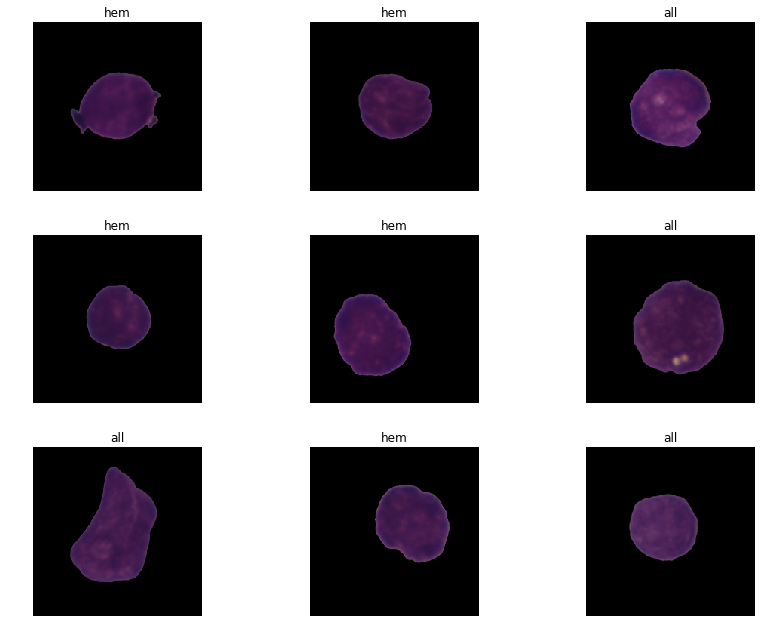

In [17]:
data.show_batch(rows=3, figsize=(12,9))

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
def auc_score(y_pred,y_true):  
    return roc_auc_score(to_np(y_true),to_np(F.sigmoid(y_pred))[:,1])

### Loss function and metrics  

In [35]:
from torch.autograd import Variable

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.25, gamma=1.):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, targ, reduction='none'):
        t = one_hot_embedding(targ, self.num_classes + 1)
        t = Variable(t[:, :-1].contiguous()).cuda()  # .cpu()
        x = pred[:, :-1]
        w = Variable(self.get_weight(x, t))
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes

    def get_weight(self,x,t):
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        return w * (1-pt).pow(self.gamma)

In [38]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate], loss_func=FocalLoss(num_classes=1, alpha=0.25, gamma=1))

In [30]:
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


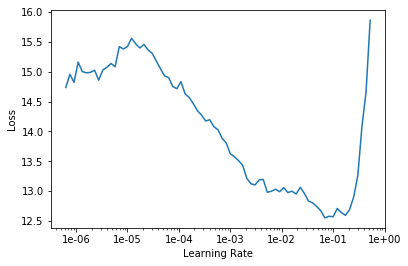

In [37]:
learn.lr_find()
learn.recorder.plot()

In [26]:
gc.collect();

In [39]:
lr = 1e-2

In [40]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,error_rate
1,6.220951,5.609900,0.331144
2,4.591843,4.741962,0.456848
3,3.577013,3.132825,0.125704
4,3.350633,2.843575,0.118199


/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Results

In [42]:
learn.loss_func = data.loss_func
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

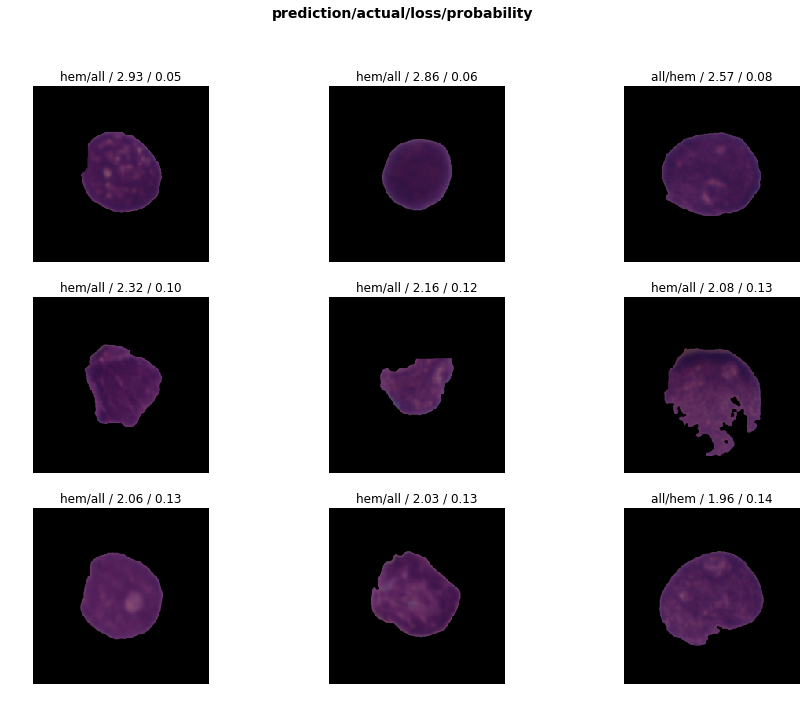

In [43]:
interp.plot_top_losses(9, figsize=(15,11))

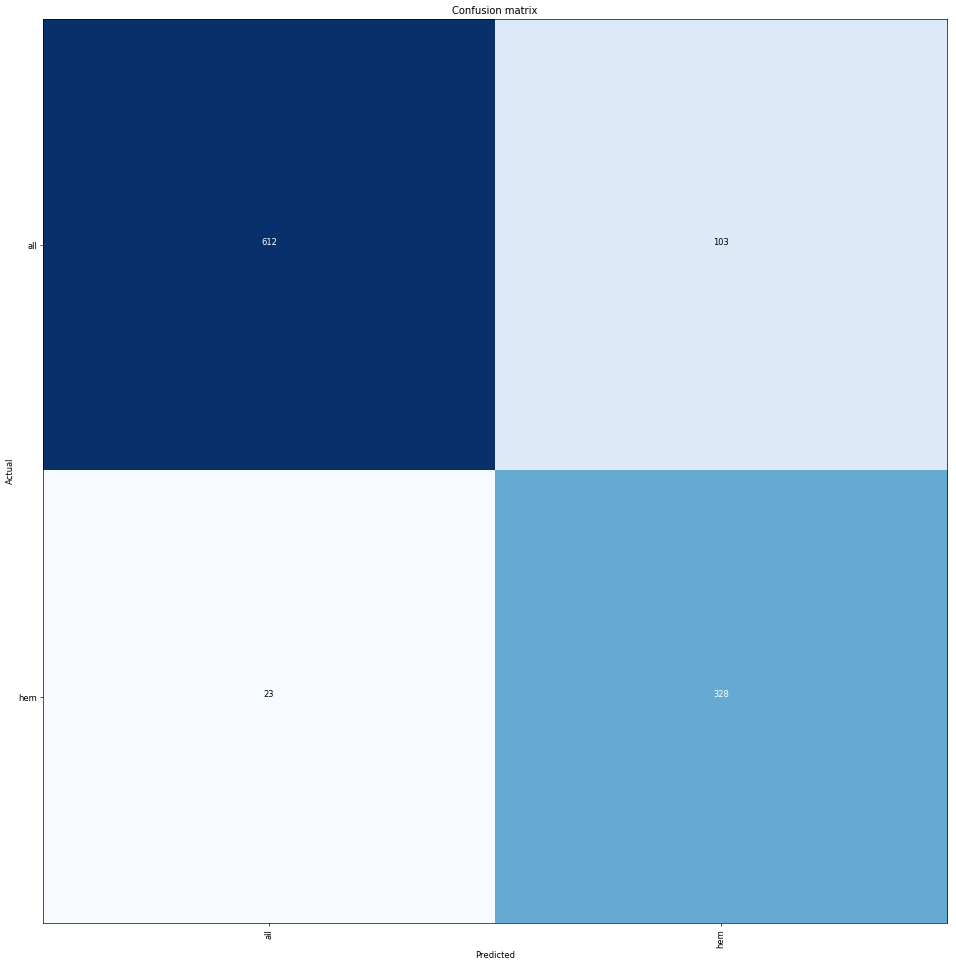

In [46]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

In [47]:
int(interp.confusion_matrix().flatten()[[1, 2]].sum())

126